In [1]:
import tensorflow as tf

C:\Users\kundami\Anaconda3\envs\PythonData\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import keras

Using TensorFlow backend.


In [3]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [4]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime
from dateutil.parser import parse
from itertools import chain
import operator
import sys
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

In [5]:
def plot_data(df,X,future,columns,title):

# lot_data(predicted, actual, future, cols,title)
    trace1 = go.Scatter(
        x=future['ds'],
        y=X,
        name='Actual Close'
    )
    #Lower_closing	Upper_closing
    trace2 = go.Scatter(
        x=future['ds'],
        y=df['Closing'],
        name='Predicted Close',
        fill=None,
        mode='lines',
        line=dict(color='rgb(143,19,131)'),        
       
    )
    data = [trace1, trace2]
    layout = go.Layout(
        title='Actual Vs Predicted using FBProphet',
        yaxis=dict(
            title='Closing Price'
        ),
        yaxis2=dict(
            title='yaxis2 title',
            titlefont=dict(
                color='rgb(148, 103, 189)'
            ),
            tickfont=dict(
                color='rgb(148, 103, 189)'
            ),
            overlaying='y',
            side='right'
        )
    )
    fig = go.Figure(data=data, layout=layout)
    #plot_url = py.plot(fig)
    py.iplot(fig)

    plt.show()

In [6]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [14]:
# Pull Kraken BTC price exchange data
#btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD')
btc_usd_price_kraken = pd.read_csv("resources/data_final.csv", sep="~")

In [20]:

#btc_usd_price_kraken.to_csv("output/kraken.csv")
btc_usd_price_kraken.set_index('Date', inplace=True)
btc_usd_price_kraken.tail()

,open,high,low,close,weighted_price,high_low_spread,midquote_price,effective_spread,7_trailing,7_next_trailing,volume_btc,volume_currency
Date,,,,,,,,,,,,
2017-12-27,15786.90,16506.33,14543.49,15396.67,15487.13,1962.84,981.42,28830.50,-1017.9650,-252.5475,45864.771929,7.107715e+08
2017-12-28,15397.34,15500.79,13560.62,14483.22,14248.84,1940.17,970.08,27026.28,-976.5550,702.4375,56110.855923,7.993687e+08
2017-12-29,14480.40,15119.53,14075.60,14448.19,14569.39,1043.93,521.97,27852.45,409.9575,2502.2425,37483.745014,5.459156e+08
2017-12-30,14450.61,14523.46,12266.14,12689.09,13329.00,2257.32,1128.66,23120.85,-2040.8800,4433.0675,57024.039238,7.599804e+08
2017-12-31,12688.51,14277.50,12538.27,13899.16,13376.96,1739.23,869.61,26059.08,-149.1425,2249.2925,34133.350349,4.578112e+08


In [35]:
print(btc_usd_price_kraken.describe)

<bound method NDFrame.describe of                 open      high       low     close  weighted_price  \
Date                                                                 
2016-01-01    431.35    435.88    428.22    433.66            99.0   
2016-01-02    434.71    435.99    431.18    434.44           100.0   
2016-01-03    434.02    434.53    424.06    429.88            91.0   
2016-01-04    430.43    435.12    428.82    433.01            98.0   
2016-01-05    432.75    435.14    429.50    432.35            97.0   
2016-01-06    432.20    432.44    427.21    429.90            92.0   
2016-01-07    429.76    459.12    429.25    458.12           115.0   
2016-01-08    457.84    463.33    446.58    453.88           131.0   
2016-01-09    453.13    456.18    447.84    449.85           122.0   
2016-01-10    449.62    450.42    441.71    449.00           111.0   
2016-01-11    449.12    452.33    442.23    449.60           114.0   
2016-01-12    449.34    449.39    435.09    435.78      

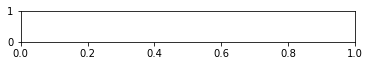

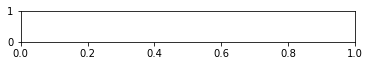

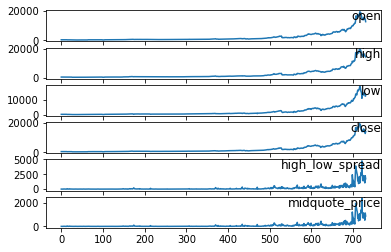

In [21]:
from matplotlib import pyplot
# load dataset
values = btc_usd_price_kraken.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(btc_usd_price_kraken.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [22]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    df.head()
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

In [23]:
values = btc_usd_price_kraken.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
df = pd.DataFrame(values)
df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11
726,15786.90,16506.33,14543.49,15396.67,713.0,1962.84,981.42,28830.50,-1017.9650,-252.5475,45864.771929,7.107715e+08
727,15397.34,15500.79,13560.62,14483.22,706.0,1940.17,970.08,27026.28,-976.5550,702.4375,56110.855923,7.993687e+08
728,14480.40,15119.53,14075.60,14448.19,708.0,1043.93,521.97,27852.45,409.9575,2502.2425,37483.745014,5.459156e+08
729,14450.61,14523.46,12266.14,12689.09,701.0,2257.32,1128.66,23120.85,-2040.8800,4433.0675,57024.039238,7.599804e+08
730,12688.51,14277.50,12538.27,13899.16,702.0,1739.23,869.61,26059.08,-149.1425,2249.2925,34133.350349,4.578112e+08


In [27]:
values = btc_usd_price_kraken.values
# integer encode direction
# We do not need a LabelEncoder since no non numeric values . Encoder helps transform non numeric to numeric values
#Eencoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1)) #Scale the values based on training + Testing dataset.
scaled = scaler.fit_transform(values)

In [28]:
#values = btc_usd_price_kraken.values
df = pd.DataFrame(scaled)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.008129,0.008004,0.008434,0.008256,0.136552,0.001033,0.001033,0.008740,0.426851,0.430496,0.038771,0.000818
1,0.008305,0.008010,0.008594,0.008297,0.137931,0.000432,0.000434,0.008861,0.430166,0.430086,0.026336,0.000427
2,0.008269,0.007935,0.008208,0.008059,0.125517,0.001626,0.001628,0.008456,0.429281,0.430403,0.044121,0.000973
3,0.008081,0.007965,0.008466,0.008222,0.135172,0.000746,0.000746,0.008742,0.429694,0.430187,0.065931,0.001680
4,0.008202,0.007966,0.008503,0.008188,0.133793,0.000607,0.000607,0.008724,0.428779,0.429064,0.048170,0.001114


In [29]:
df = pd.DataFrame(scaled)
df.head()
# frame as supervised learning check the original values
reframed = series_to_supervised(values, 1, 1) #Shift the timeseries values
df = pd.DataFrame(reframed)
df.tail()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
726,13991.16,16166.05,13896.15,15788.43,712.0,2269.90,1134.95,29306.96,-1895.4000,-1020.1475,...,14543.49,15396.67,713.0,1962.84,981.42,28830.50,-1017.9650,-252.5475,45864.771929,7.107715e+08
727,15786.90,16506.33,14543.49,15396.67,713.0,1962.84,981.42,28830.50,-1017.9650,-252.5475,...,13560.62,14483.22,706.0,1940.17,970.08,27026.28,-976.5550,702.4375,56110.855923,7.993687e+08
728,15397.34,15500.79,13560.62,14483.22,706.0,1940.17,970.08,27026.28,-976.5550,702.4375,...,14075.60,14448.19,708.0,1043.93,521.97,27852.45,409.9575,2502.2425,37483.745014,5.459156e+08
729,14480.40,15119.53,14075.60,14448.19,708.0,1043.93,521.97,27852.45,409.9575,2502.2425,...,12266.14,12689.09,701.0,2257.32,1128.66,23120.85,-2040.8800,4433.0675,57024.039238,7.599804e+08
730,14450.61,14523.46,12266.14,12689.09,701.0,2257.32,1128.66,23120.85,-2040.8800,4433.0675,...,12538.27,13899.16,702.0,1739.23,869.61,26059.08,-149.1425,2249.2925,34133.350349,4.578112e+08


In [30]:
# frame as supervised learning check the original values
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[12,13,14,16,17,18,19,20,21,22,23]], axis=1, inplace=True) #remove unnessary columns
df2 = pd.DataFrame(reframed)

In [32]:
df2.tail()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var4(t)
726,0.717710,0.816573,0.739297,0.811654,0.982069,0.478081,0.478082,0.786476,0.267117,0.341766,0.235543,0.278513,0.791156
727,0.811681,0.834064,0.774426,0.791156,0.983448,0.413330,0.413331,0.773450,0.341952,0.407233,0.252600,0.299063,0.743362
728,0.791295,0.782377,0.721089,0.743362,0.973793,0.408549,0.408548,0.724124,0.345484,0.488681,0.311631,0.336438,0.741529
729,0.743312,0.762779,0.749035,0.741529,0.976552,0.219556,0.219558,0.746711,0.463736,0.642183,0.204315,0.229517,0.649489
730,0.741753,0.732140,0.650841,0.649489,0.966897,0.475428,0.475429,0.617351,0.254710,0.806859,0.316892,0.319822,0.712803


In [36]:
# split into train and test sets
#train_Y/test_Y- Price Open.
timeseries_values = reframed.values
n_train_hours = 650
train = timeseries_values[:n_train_hours, :]
test = timeseries_values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(650, 1, 12) (650,) (80, 1, 12) (80,)


In [37]:
dftest = pd.DataFrame(test)
dftest.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.237736,0.265154,0.245998,0.270108,0.889655,0.132823,0.132826,0.265300,0.524629,0.451515,0.283568,0.110584,0.280727
1,0.270110,0.286789,0.277391,0.280727,0.896552,0.099594,0.099596,0.280705,0.537759,0.458251,0.366680,0.154710,0.289148
2,0.280741,0.284367,0.287017,0.289148,0.902069,0.052250,0.052250,0.295643,0.546112,0.447671,0.110900,0.050254,0.283259
3,0.289075,0.285640,0.280413,0.283259,0.893793,0.083133,0.083131,0.285486,0.522055,0.454426,0.154870,0.067576,0.286224
4,0.283343,0.283026,0.287060,0.286224,0.900690,0.046582,0.046582,0.293323,0.512658,0.441534,0.114639,0.051783,0.278503


In [38]:
print(train_X.ndim)
print(train_y.ndim)
print(test_X.ndim)
print(test_y.ndim)

3
1
3
1


In [39]:
train_X_orig, train_y_orig = train[:, :-1], train[:, -1]
test_X_orig, test_y_orig = test[:, :-1], test[:, -1]

In [43]:
dftrA = pd.DataFrame(train)
dftrA.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.008129,0.008004,0.008434,0.008256,0.136552,0.001033,0.001033,0.008740,0.426851,0.430496,0.038771,0.000818,0.008297
1,0.008305,0.008010,0.008594,0.008297,0.137931,0.000432,0.000434,0.008861,0.430166,0.430086,0.026336,0.000427,0.008059
2,0.008269,0.007935,0.008208,0.008059,0.125517,0.001626,0.001628,0.008456,0.429281,0.430403,0.044121,0.000973,0.008222
3,0.008081,0.007965,0.008466,0.008222,0.135172,0.000746,0.000746,0.008742,0.429694,0.430187,0.065931,0.001680,0.008188
4,0.008202,0.007966,0.008503,0.008188,0.133793,0.000607,0.000607,0.008724,0.428779,0.429064,0.048170,0.001114,0.008060


In [44]:
dftrX = pd.DataFrame(train_X_orig)
dftrX.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.008129,0.008004,0.008434,0.008256,0.136552,0.001033,0.001033,0.008740,0.426851,0.430496,0.038771,0.000818
1,0.008305,0.008010,0.008594,0.008297,0.137931,0.000432,0.000434,0.008861,0.430166,0.430086,0.026336,0.000427
2,0.008269,0.007935,0.008208,0.008059,0.125517,0.001626,0.001628,0.008456,0.429281,0.430403,0.044121,0.000973
3,0.008081,0.007965,0.008466,0.008222,0.135172,0.000746,0.000746,0.008742,0.429694,0.430187,0.065931,0.001680
4,0.008202,0.007966,0.008503,0.008188,0.133793,0.000607,0.000607,0.008724,0.428779,0.429064,0.048170,0.001114


In [45]:
dftr = pd.DataFrame(train_y_orig)
dftr.head()

,0
0,0.008297
1,0.008059
2,0.008222
3,0.008188
4,0.008060


In [46]:
dfteX = pd.DataFrame(test_X_orig)
dfteX.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.237736,0.265154,0.245998,0.270108,0.889655,0.132823,0.132826,0.265300,0.524629,0.451515,0.283568,0.110584
1,0.270110,0.286789,0.277391,0.280727,0.896552,0.099594,0.099596,0.280705,0.537759,0.458251,0.366680,0.154710
2,0.280741,0.284367,0.287017,0.289148,0.902069,0.052250,0.052250,0.295643,0.546112,0.447671,0.110900,0.050254
3,0.289075,0.285640,0.280413,0.283259,0.893793,0.083133,0.083131,0.285486,0.522055,0.454426,0.154870,0.067576
4,0.283343,0.283026,0.287060,0.286224,0.900690,0.046582,0.046582,0.293323,0.512658,0.441534,0.114639,0.051783


In [47]:
dfte = pd.DataFrame(test_y_orig)
dfte.head()

,0
0,0.280727
1,0.289148
2,0.283259
3,0.286224
4,0.278503


Train on 650 samples, validate on 80 samples
Epoch 1/50
 - 1s - loss: 0.0030 - val_loss: 0.2438
Epoch 2/50
 - 0s - loss: 0.0023 - val_loss: 0.1911
Epoch 3/50
 - 0s - loss: 0.0027 - val_loss: 0.1580
Epoch 4/50
 - 0s - loss: 0.0026 - val_loss: 0.1373
Epoch 5/50
 - 0s - loss: 0.0022 - val_loss: 0.1212
Epoch 6/50
 - 0s - loss: 0.0017 - val_loss: 0.1055
Epoch 7/50
 - 0s - loss: 0.0013 - val_loss: 0.0893
Epoch 8/50
 - 0s - loss: 0.0011 - val_loss: 0.0736
Epoch 9/50
 - 0s - loss: 8.7362e-04 - val_loss: 0.0596
Epoch 10/50
 - 0s - loss: 7.0416e-04 - val_loss: 0.0476
Epoch 11/50
 - 0s - loss: 5.5759e-04 - val_loss: 0.0375
Epoch 12/50
 - 0s - loss: 4.3747e-04 - val_loss: 0.0291
Epoch 13/50
 - 0s - loss: 3.4744e-04 - val_loss: 0.0222
Epoch 14/50
 - 0s - loss: 2.8542e-04 - val_loss: 0.0167
Epoch 15/50
 - 0s - loss: 2.4473e-04 - val_loss: 0.0126
Epoch 16/50
 - 0s - loss: 2.1932e-04 - val_loss: 0.0095
Epoch 17/50
 - 0s - loss: 2.0445e-04 - val_loss: 0.0073
Epoch 18/50
 - 0s - loss: 1.9629e-04 - val_l

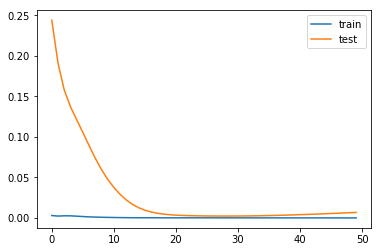

In [48]:
# design network
#We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.
#We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.
#The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam') #mae
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [49]:
def plot_data1(df,X,future,columns,title):

# lot_data(predicted, actual, future, cols,title)
    trace1 = go.Scatter(
        x=future['ds'],
        y=X,
        name='Actual Close'
    )
    #Lower_closing	Upper_closing
    trace2 = go.Scatter(
        x=future['ds'],
        y=df['Closing'],
        name='Predicted Close',
        fill=None,
        mode='lines',
        line=dict(color='rgb(143,19,131)'),        
       
    )
    data = [trace1, trace2]
    layout = go.Layout(
        title='Actual Vs Predicted using FBProphet',
        yaxis=dict(
            title='Closing Price'
        ),
        yaxis2=dict(
            title='yaxis2 title',
            titlefont=dict(
                color='rgb(148, 103, 189)'
            ),
            tickfont=dict(
                color='rgb(148, 103, 189)'
            ),
            overlaying='y',
            side='right'
        )
    )
    fig = go.Figure(data=data, layout=layout)
    #plot_url = py.plot(fig)
    py.iplot(fig)

    plt.show()

In [50]:
# make a prediction and invert the scaling for predicted
ypred = model.predict(test_X)
test_X_revert = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_ypred = np.concatenate((ypred, test_X_revert[:, 1:]), axis=1)
inv_ypred = scaler.inverse_transform(inv_ypred)
inv_yhat = inv_ypred[:,0]


# invert scaling for actual
test_y_revert = test_y.reshape((len(test_y), 1))
inv_yorig = np.concatenate((test_y_revert, test_X_revert[:, 1:]), axis=1)
inv_yorig = scaler.inverse_transform(inv_yorig)
inv_y = inv_yorig[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat)) #Pass Original and predicted
print('Test RMSE: %.3f' % rmse)


Test RMSE: 1575.223


In [51]:
def plot_data2(actual,predict,real_data,columns,title):
# lot_data(predicted, actual, future, cols,title)
    df = pd.DataFrame(real_data)
    data_series = df["Date"]
    print("Here")
    # lot_data(predicted, actual, future, cols,title)
    df = pd.DataFrame(real_data)
    
    trace1 = go.Scatter(
        x=data_series,
        y=actual,
        name='Actual Close'
    )
    #Lower_closing	Upper_closing
    trace2 = go.Scatter(
        x=data_series,
        y=predict,
        name='Predicted Close',
        fill=None,
        mode='lines',
        line=dict(color='rgb(143,19,131)'),        
       
    )
    data = [trace1, trace2]
    layout = go.Layout(
        title='Actual Vs Predicted using Google TensorFlow RNN',
        yaxis=dict(
            title='Closing Price'
        ),
        yaxis2=dict(
            title='yaxis2 title',
            titlefont=dict(
                color='rgb(148, 103, 189)'
            ),
            tickfont=dict(
                color='rgb(148, 103, 189)'
            ),
            overlaying='y',
            side='right'
        )
    )
    fig = go.Figure(data=data, layout=layout)
    #plot_url = py.plot(fig)
    py.iplot(fig)

    plt.show()
    print("Here")

In [52]:
print(len(inv_y))
print(len(inv_yhat))


80
80


In [53]:
btc_usd_price_kraken.head()

,open,high,low,close,weighted_price,high_low_spread,midquote_price,effective_spread,7_trailing,7_next_trailing,volume_btc,volume_currency
Date,,,,,,,,,,,,
2016-01-01,431.35,435.88,428.22,433.66,99.0,7.66,3.83,859.65,-22.526170,20.216172,8749.673805,3789078.83
2016-01-02,434.71,435.99,431.18,434.44,100.0,4.81,2.41,864.07,16.345000,15.412500,6591.310053,2862465.49
2016-01-03,434.02,434.53,424.06,429.88,91.0,10.47,5.24,849.28,5.965003,19.124997,9678.402186,4157151.63
2016-01-04,430.43,435.12,428.82,433.01,98.0,6.30,3.15,859.72,10.813537,16.589110,13463.971066,5832898.79
2016-01-05,432.75,435.14,429.50,432.35,97.0,5.64,2.82,859.06,0.085000,3.425000,10381.184703,4492484.21


In [54]:
cols = ["Mean", "Lower_closing", "Upper_closing"]
title = "Closing price distribution of bitcoin"
#btc_usd_price_kraken.index = range(len(btc_usd_price_kraken))
#plot_data2(inv_y,inv_yhat, cols ,title)
btc_usd_price_kraken.reset_index(inplace=True)
real_data = btc_usd_price_kraken[651:len(btc_usd_price_kraken)]
#real_data
#plot_data2(inv_y,inv_yhat, real_data, cols ,title)

In [55]:
cols = ["Mean", "Lower_closing", "Upper_closing"]
title = "Closing price distribution of bitcoin"
plot_data2(inv_y,inv_yhat, real_data, cols ,title)

Here


Here


In [ ]:

#print(inv_ypred.ndim)
#df = pd.DataFrame(inv_ypred)
#df.to_csv("output/calc.csv")

In [ ]:
#print(inv_yorig.ndim)
#df = pd.DataFrame(inv_yorig)
#df.to_csv("output/orig.csv")

<bound method Container.summary of <keras.models.Sequential object at 0x0000029087667F28>>
